29
1.0
[1. 0. 1.]


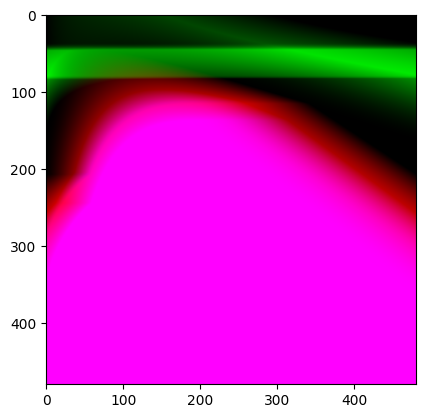

In [5]:
from agrn import grn
import numpy as np
import matplotlib.pyplot as plt
from agrn.genome import random_genome



nin = 2
nout = 6
nreg = 1

genome = random_genome(nin, nout, nreg)
print(len(genome))

gsquare = grn.GRN(genome, nin=nin, nout=nout)
# gsquare.random(nin=nin, nout=nout, nreg=nreg)



N = 480


matrix = np.zeros((N,N,3))
gsquare.step(25)
for i in range(N):
    for j in range(N):
        gsquare.set_input([i/N, j/N])
        gsquare.step(2)   
        out = gsquare.get_output()
        # if max(out) > 1:
        #     print("wtf")
        # print(out)
        matrix[i][j] = out


print(np.max(matrix))
plt.imshow(matrix)

print(out)
# plt.savefig("test.png")

In [ ]:
from grn import GRN
import matplotlib.pyplot as plt



nin = 2
nout = 3
nreg = 1

genome = random_genome(nin, nout, nreg)
gsquare = grn.GRN(genome)

print(gsquare.genome)
gsquare.reset()

gsquare.step(nsteps=25)

outputs = []
outputs.append(gsquare.get_output())


for i in range(1000):
    # g.set_input([0.5, 0.5])
    gsquare.set_input([0.1])
    gsquare.step()
    outputs.append(gsquare.get_output())
    # print(g.concentrations)

plt.plot(outputs)

In [ ]:
print("grn concentrations summ should be  1 : ", np.sum(gsquare.concentrations[nin:]))
print("grn concentrations ", gsquare.concentrations)
print("grn genome ", gsquare.genome)
print("len genome ",len(gsquare.genome))


In [ ]:
import matplotlib.pyplot as plt 

tg = GRN()
gsquare.reset()

tg.from_genome(gsquare.genome)
tg.from_genome_cmaes(es.best.x)
# tg.random(nin=n_in, nout=n_out, nreg=10)
print(es.best.x)

yg = problem.run_grn(gsquare)
ytg = problem.run_grn(tg)
# ytg = problem.run_grn(r)
# problem.run_grn(g)
plt.plot(xtrain, yg, label="grn")
plt.plot(xtrain, ytg, label="tg")
plt.plot(xtrain, ytrain, label = "target")

err = np.linalg.norm(ytrain - np.array(ytg))
print("err", err)
plt.legend()
# g.from_genome_cmaes(cma_result[0])
# print(tg)
# print("best grn fit: ", problem.run_grn(tg.genome))

# DEAP test 

In [ ]:
import random
from deap import base, creator, tools, algorithms




# 1. Define the fitness and individual types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

# 2. Set up the toolbox (genetic operators)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)  # Gene: random float in [0, 1]
toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_float,
    n=5  # Genome length = 5
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    return sum(individual),

# 3. Define genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Crossover (blend parents)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=0.5, low=0.0, up = 1.0, indpb=0.1)  # Mutation
toolbox.register("select", tools.selTournament, tournsize=3)  # Selection
toolbox.register("evaluate", evaluate)  # Fitness = sum of genome values

# 4. Create population and run the GA
population = toolbox.population(n=50)  # 50 individuals
algorithms.eaSimple(
    population,
    toolbox,
    cxpb=0.0,       # Crossover probability
    mutpb=0.2,      # Mutation probability
    ngen=100,        # Generations
    verbose=True    # Print progress
)

# 5. Print the best solution
best_individual = tools.selBest(population, k=)[0]
print(f"\nBest genome: {best_individual}")
print(f"Best fitness (sum): {best_individual.fitness.values[0]}")

In [1]:
from pathlib import Path
import sys
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import random
from deap import base, creator, tools, algorithms
import numpy as np
from agrn.grn import GRN
import agrn.problem as p 
import matplotlib.pyplot as plt
from agrn.genome import random_genome
from agrn.mutation import *
from agrn.crossover import *
from functools import partial

# grn hyperparameters 
nin = 1
nout = 1
nreg = 0

a = 1
f = 0

size = nin + nout + nreg
genome_size = size*3 + 2 # 2 for beta and delta

# create the problem instance 
t = np.linspace(0, 1, 500)
xtrain = t
ytrain = np.sin(xtrain*10)**2 # 
# ytrain = t


# genome_size = random_genome(nin, nout, nreg).size
problem = p.RegressionProblem(xtrain, ytrain, nin, nout, nreg)
# problem = p.FrenchFlagProblem(nin=nin, nout=nout, nreg=nreg)


def evaluate(individual):
    fit, _ = problem.eval(individual)
    return fit,

# 1. Define the fitness and individual types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize fitness
creator.create("Individual", list, fitness=creator.FitnessMax)


def init_indiv(nin, nout, start_nreg):
    return random_genome(nin, nout, start_nreg)

init_indiv_fun = partial(init_indiv, nin=problem.nin, nout=problem.nout, start_nreg=nreg)
# 2. Set up the toolbox (genetic operators)
toolbox = base.Toolbox()
toolbox.register("individual",tools.initIterate, creator.Individual,init_indiv_fun,)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 3. Define genetic operators
# toolbox.register("mate", tools.crossover, nin=nin, nout=nout)  # Crossover (blend parents)

toolbox.register("mate", tools.cxBlend, alpha = 1.0)  # Crossover (blend parents)
toolbox.register("mutate", mutate, problem.nin, nout=problem.nout, betamin=0.2, betamax=2, deltamin=0.2, deltamax=2)  # Mutation
# toolbox.register("mutate", lambda individual: tools.mutGaussian(individual, mu=0, sigma=0.5, indpb=0.5))  # Mutation

toolbox.register("select", tools.selTournament, tournsize=3)  # Selection
toolbox.register("evaluate", problem.eval)  # Fitness = sum of genome values

population = toolbox.population(n=1000)  # 50 individuals
hof = tools.HallOfFame(1)  # Track best individual

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_fit.register("avg", np.mean)
stats_fit.register("min", np.min)
stats_fit.register("max", np.max)


algorithms.eaMuPlusLambda(
    population,
    toolbox,
    lambda_=10,
    mu=5,
    cxpb=0.3,       # Crossover probability
    mutpb=0.7,      # Mutation probability
    ngen=10,        # Generations
    halloffame=hof,
    stats=stats_fit,
    verbose=True    # Print progress
)

# 5. Print the best solution
best_individual = tools.selBest(population, k=1)[0]
print(f"\nBest genome: {len(best_individual)}")
print(f"Best fitness (sum): {best_individual.fitness.values[0]}")


gen	nevals	avg     	min     	max     
0  	1000  	-297.918	-314.564	-209.603
1


TypeError: object of type 'int' has no len()

In [11]:
a = np.array([1,2,3])
b = np.array([4,5,6])
np.linalg.norm(a-b)


5.196152422706632

error on problem -37.94235151859454


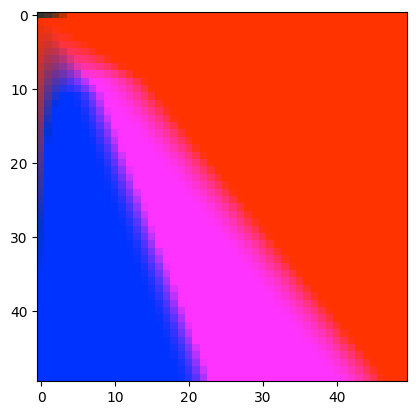

In [4]:
grn = GRN(best_individual, nin=1, nout=1)
# grn.setup()

t = np.linspace(0, 1, 500)

err, ypred = problem.eval(best_individual)
# grn.setup()
# grn.reset()
# grn.warmup(25)
# y=  []
# for ti in t:
#     grn.set_input([ti])
#     grn.step()
#     y.append(grn.get_output())
# print(grn.concentrations)

# plt.plot(t, y[:])
# plt.plot(t, np.sin(t)**2)
# plt.show()

plt.imshow(ypred)
# plt.plot(t, ypred,)
# # plt.plot(t, np.sin(t**10)**2)
# plt.plot(t, problem.ytrain)
# np.sum(abs(ypred-problem.ytrain))


# print("error on test set", np.sum(abs(ypred-problem.ytrain)))
print("error on problem", err)
# np.linalg.norm(ypred - np.sin(t)**2)
# np.linalg.norm(y[:] - np.sin(t)**2)

In [ ]:
len(best_individual), best_individual

print("best_individual", best_individual)
print(grn)

[0.2 0.2 0.2 0.2 0.2]
5
concentration after warmup [0.         0.45259131 0.         0.         0.9327978 ]
{'nin': 1, 'nout': 1, 'nreg': 3, 'beta': 0.9116682507312829, 'delta': 1.8735, 'a': 0, 'f': 1, 'idsize': 1.0, 'identifiers': array([0.32002262, 0.53875186, 0.30636835, 0.13747037, 0.97652842]), 'enhancers': array([0.48307438, 0.48090997, 0.7544553 , 0.74180602, 0.37003506]), 'inhibiters': array([0.98429017, 0.76989283, 0.84782954, 0.90306246, 0.57703009])}
enh matrix  [[0.35714815 0.30327436 0.36451054 0.46537989 0.56844835]
 [0.35599184 0.30429112 0.36333567 0.46397214 0.57005546]
 [0.52569548 0.38618598 0.53540004 0.6643495  0.38981802]
 [0.51680683 0.37904973 0.52640589 0.65415666 0.39710734]
 [0.30062632 0.36018852 0.30704131 0.39585671 0.65588967]]
inh matrix shape  [[0.70313635 0.53358003 0.71452899 0.86125126 0.2814735 ]
 [0.53667582 0.39503314 0.54650795 0.67689626 0.38105993]
 [0.59427475 0.44202219 0.60472603 0.74191436 0.33914076]
 [0.63718021 0.47767056 0.6480382  0.78

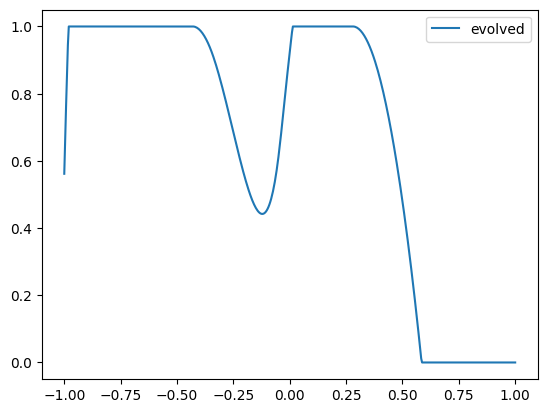

In [4]:
import numpy as np
from grn import GRN
from genome import *   
import matplotlib.pyplot as plt

# grn evolved with great from pygnr should looks like a square 


beta = 0.9116682507312829
delta = 1.8735
identifiers = [0.32002262, 0.53875186, 0.30636835, 0.13747037, 0.97652842]
enhancers = [0.48307438, 0.48090997, 0.7544553 , 0.74180602, 0.37003506]
inhibiters = [0.98429017, 0.76989283, 0.84782954, 0.90306246, 0.57703009]
a = 0
f = 0
genome = encode_genome(beta, delta, identifiers, enhancers, inhibiters)
gsquare = GRN(genome, nin=1, nout=1)

t = np.linspace(-1, 1, 500)

gsquare.setup()

print(gsquare.concentrations)
gsquare.warmup(25)
print(gsquare.size)
print("concentration after warmup", gsquare.concentrations)
ys = []
for ti in t:
    gsquare.set_input([ti])
    gsquare.step()
    ys.append(gsquare.get_output())


plt.plot(t, ys, label="evolved")
# plt.plot(t, ytrain, '.', label = "target")
plt.legend()

print(gsquare)
print("enh matrix ", gsquare.enh_affinity_matrix)
print("inh matrix shape ", gsquare.inh_affinity_matrix)

In [3]:
print(gsquare.genome)

gtest = GRN()
gtest.random(nin=1, nout=1, nreg=3)
gsquare_genome = gsquare.genome
gtest.from_genome(gsquare.genome)

gtest.warmup(25)
print(gtest.size)
print("concentration after warmup", gsquare.concentrations)
yss = []
for ti in t:
    gtest.set_input([ti])
    gtest.step()
    yss.append(gtest.get_output())


plt.plot(t, ys, '.' , label="evolved")
plt.plot(t, yss, '.', label="evolved")
# plt.plot(t, ytrain, '.', label = "target")
plt.legend()

NameError: name 'gsquare' is not defined

In [ ]:
def french_flag(N):
    """
    Create a NxNx3 matrix representing the French flag.
    
    Blue | White | Red
    """
    flag = np.zeros((N, N, 3), dtype=np.uint8)  # RGB uint8 values 0-255

    # Width of each stripe
    stripe_width = N // 3

    # Blue stripe
    flag[:, :stripe_width, :] = [0, 85, 164]  # RGB for blue

    # White stripe
    flag[:, stripe_width:2*stripe_width, :] = [255, 255, 255]

    # Red stripe
    flag[:, 2*stripe_width:, :] = [239, 65, 53]  # RGB for red

    return flag/255.0

# Example usage
N = 50
flag = french_flag(N)
plt.imshow(flag)


def eval(individual):
    fit, _ = problem.eval(individual)
    return fit,

Starting 20 processes
gen	nevals	avg     	min     	max     	std    	median  
0  	500   	-298.045	-314.797	-194.035	10.5409	-297.441
1  	1000  	-290.441	-297.441	-194.035	15.3622	-296.024
2  	1000  	-281.249	-295.525	-184.277	21.94  	-290.232
3  	1000  	-266.109	-287.963	-181.096	26.2751	-278.368
4  	1000  	-247.641	-277.078	-181.096	25.8575	-257.714
5  	1000  	-225.372	-256.003	-181.096	21.2023	-230.758
6  	1000  	-208.778	-231.383	-181.096	14.6771	-208.582
7  	1000  	-196.214	-210.102	-181.096	6.83469	-194.405
8  	1000  	-190.997	-195.312	-181.096	3.76556	-192.195
9  	1000  	-188.382	-193.581	-180.1  	3.46132	-189.238
10 	1000  	-185.714	-189.854	-179.291	2.53565	-185.575
11 	1000  	-184.006	-186.434	-179.291	1.44413	-184.266
12 	1000  	-183.156	-184.558	-179.175	1.0769 	-183.258
13 	1000  	-182.584	-183.897	-179.175	0.95392	-182.695
14 	1000  	-182.126	-183.062	-178.89 	0.861624	-182.381
15 	1000  	-181.815	-182.663	-178.778	0.885203	-182.167
16 	1000  	-181.482	-182.382	-178.778	0.9

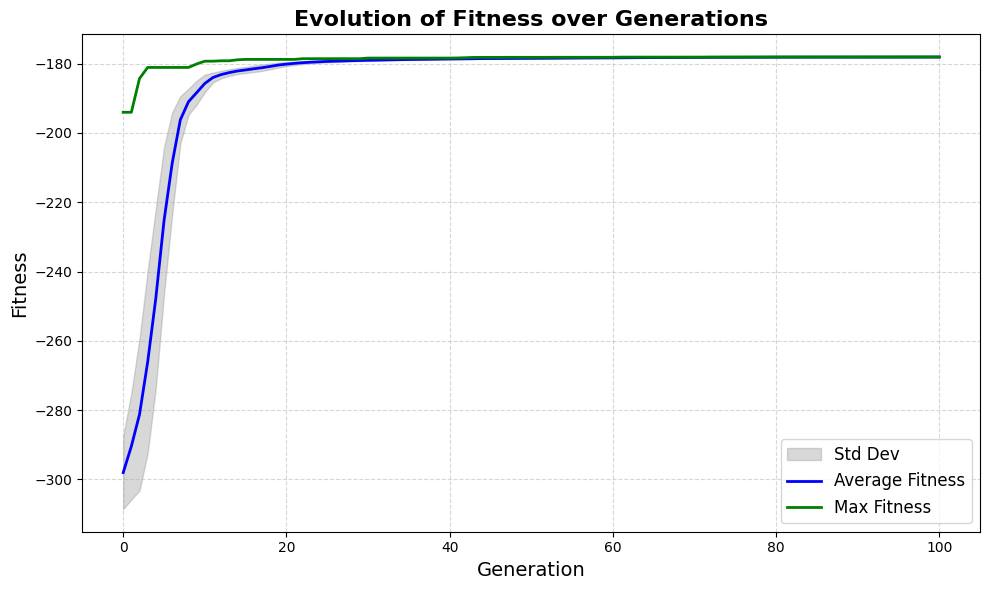

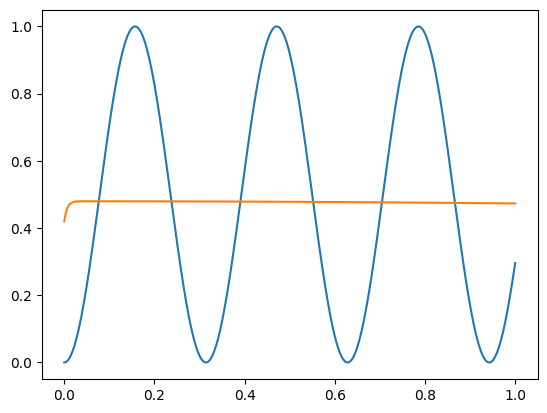

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from agrn.evolver import *
from agrn.genome import *
from agrn.problem import *
from agrn.grn import *

t = np.linspace(0, 1, 500)
ytrain = np.sin(t*10)**2
p = RegressionProblem(t, ytrain, nin=1, nout=1, nreg=0)


e = EATMuPlusLambda(nin=p.nin, nout=p.nout, nreg=0)
alg = e.run(100, p.eval, 500, 1000, multiproc=True, verbose=True)
e.visualize_evolutions()
alg[0][0]

g = GRN(alg[0][0], nin=p.nin, nout=p.nout)
p.run_grn(g)

plt.plot(t, ytrain)
plt.plot(t, p.run_grn(g))

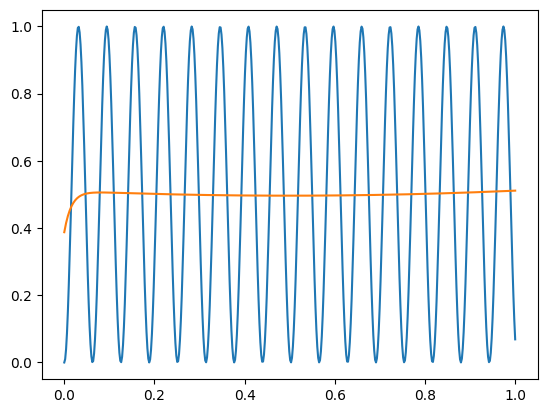